In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
! pip install ../
# ! pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Processing /home/chetan/dev/learn_to_pick
  Preparing metadata (setup.py) ... done
  Created wheel for learn-to-pick: filename=learn_to_pick-0.0.3-py3-none-any.whl size=31195 sha256=bee6266df7b0bde64de2e58bff8c435340c315aa8fa9cfa3c84751c22a26fab1
  Stored in directory: /tmp/pip-ephem-wheel-cache-zigo2ps9/wheels/18/bf/25/d8dda8a9a6b5284eaed510a4708ef9b22b9894a5e94b329ea2
Successfully built learn-to-pick
  Attempting uninstall: learn-to-pick
    Found existing installation: learn-to-pick 0.0.3
    Uninstalling learn-to-pick-0.0.3:
      Successfully uninstalled learn-to-pick-0.0.3


In [12]:
import torch
print(torch.__version__)

2.0.1+cu117


This is an example of a news recommendation system. We have two users `Tom` and `Anna`, and some article topics that we want to recommend to them.

The users come to the news site in the moring and in the afternoon and we want to learn what topic to recommend to which user at which time of day.

- The action space here are the `article` topics
- The criteria/context are the user and the time of day
- The score is whether the user liked or didn't like the recommendation (simulated in the `CustomSelectionScorer`)

In [13]:
import random

users = ["Tom", "Anna"]
times_of_day = ["morning", "afternoon"]
articles = ["politics", "sports", "music", "food", "finance", "health", "camping"]

def choose_user(users):
    return random.choice(users)


def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)


In [14]:
import learn_to_pick

class CustomSelectionScorer(learn_to_pick.SelectionScorer):
    def get_score(self, user, time_of_day, article):
        preferences = {
            'Tom': {
                'morning': 'politics',
                'afternoon': 'music'
            },
            'Anna': {
                'morning': 'sports',
                'afternoon': 'politics'
            }
        }

        # if the article was the one the user prefered for this time of day, return 1.0
        # if it was a different article return 0.0
        return int(preferences[user][time_of_day] == article)

    def score_response(
        self, inputs, picked, event: learn_to_pick.PickBestEvent
    ) -> float:
        chosen_article = picked["article"]
        user = event.based_on["user"]
        time_of_day = event.based_on["time_of_day"]
        score = self.get_score(user, time_of_day, chosen_article)
        return score

Initializing two pickers, one with the default decision making policy `picker` and one with a random decision making policy `random_picker`.

Both pickers are initialized with the `CustomSelectionScorer` and with `metrics_step` and `metrics_window` in order to keep track of how the score evolves in a rolling window average fashion.

In [15]:
from learn_to_pick import PyTorchPolicy

pytorch_picker = learn_to_pick.PickBest.create(
    metrics_step=100, metrics_window_size=100, policy=PyTorchPolicy(), selection_scorer=CustomSelectionScorer())
random_picker = learn_to_pick.PickBest.create(
    metrics_step=100, metrics_window_size=100, policy=learn_to_pick.PickBestRandomPolicy(), selection_scorer=CustomSelectionScorer())

Device: cuda


In [16]:
# randomly pick users and times of day

for i in range(2500):
    user = choose_user(users)
    time_of_day = choose_time_of_day(times_of_day)

    random_picker.run(
        article = learn_to_pick.ToSelectFrom(articles),
        user = learn_to_pick.BasedOn(user),
        time_of_day = learn_to_pick.BasedOn(time_of_day),
    )

    pytorch_picker.run(
        article = learn_to_pick.ToSelectFrom(articles),
        user = learn_to_pick.BasedOn(user),
        time_of_day = learn_to_pick.BasedOn(time_of_day),
    )

Plot the score evolution for the default picker and the random picker. We should observe the default picker to **learn** to make good suggestions over time.

The final average score for the default policy, calculated over a rolling window, is: 0.93
The final average score for the random policy, calculated over a rolling window, is: 0.53


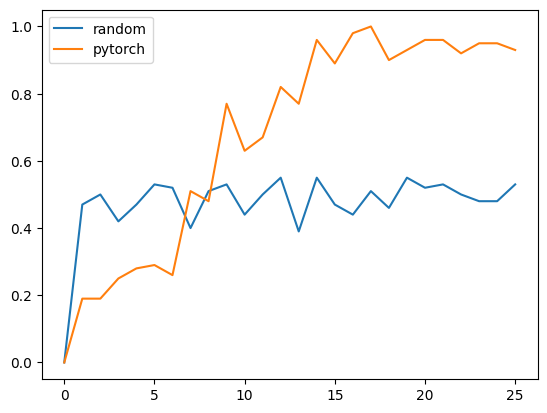

In [17]:
from matplotlib import pyplot as plt
random_picker.metrics.to_pandas()['score'].plot(label="random")
pytorch_picker.metrics.to_pandas()['score'].plot(label="pytorch")

plt.legend()

print(f"The final average score for the default policy, calculated over a rolling window, is: {pytorch_picker.metrics.to_pandas()['score'].iloc[-1]}")
print(f"The final average score for the random policy, calculated over a rolling window, is: {random_picker.metrics.to_pandas()['score'].iloc[-1]}")
